# SyriaTel: Know Your Customer

**Data Science Team:** David Johnson, Elina Rankova

<div style="width: 100%; text-align: center;">
  <img src="https://media.licdn.com/dms/image/C4D12AQH-Qk_eTZv6iA/article-cover_image-shrink_720_1280/0/1622638706496?e=1715212800&v=beta&t=a3k-gWfqrlzfv7inhVBpUU9xxPjnJ0of4viF4tFu-Oc" width="720" height="450" style="margin: 0 auto;"/>
</div>

<u>image source</u>: <a href="https://www.linkedin.com/pulse/churn-analysis-smriti-saini/">Churn Analysis Article</a>

## 1. Business Problem and Understanding

**Stakeholders:** Director of Customer Operations, Customer Operations Manager, Customer Retention Manager, Customer Support Manager


The business problem at hand is to predict customer churn for SyriaTel, a telecommunications company, in order to minimize revenue loss and enhance customer retention efforts. With customer attrition posing a significant challenge to profitability in the telecom industry, SyriaTel seeks to identify patterns and trends within its customer base that indicate potential churn. By leveraging historical data and predictive modeling techniques, the aim is to develop a classifier that can accurately forecast which customers are likely to discontinue their services, enabling SyriaTel to implement targeted retention strategies and ultimately strengthen its competitive position in the market.


**The goal:** Create a model to predict churn in telecom members contacting support. We are aiming to reduce the amount of cases in which members are mistakenly identified as retained (false negative) vs mistakenly identified as churned to ensure we capture all members who may churn (positive).

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## 2. Data Understanding

For this analysis, the SyriaTel churn data was sourced from <a href = "https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset">Kaggle</a>

The dataset contains data on the customers of a Telecom company. Each row represents a customer and the columns contain customer’s attributes such as minutes, number of calls, and charge for each time of day and international. In addition we also have information about the customer's voicemail and customer call behavior.

In [2]:
# Load in csv

df = pd.read_csv('Data/tel_cust_curn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


The dataset has no missingness and most columns are numeric. Will have to explore the object type columns to assess whether to drop or transform. With 3333 entries, the dataset is not small but not the largest, depending on the distribution of the target, may need to consider re-sampling.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Before getting into the data exploration, we will rename the columns with _ instead of spaces. We can also drop phone number right off the bat from the dataset as this is not something we can use to determine churn.

In [4]:
# Rename columns with '_' instead of spaces

df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

It looks like we definitely have **class imbalance** and will have to address that in our preprocessing, after splitting our train/test data.

## 3. Data Exloration

### Target Variable: `churn`

- Of the 3,333 customers in this dataset, 483 terminated their contract with SyriaTel.
- This is an imbalanced dataset, with 14.5% of customers lost. We will need to address this before modeling in our preprocessing.
- We will also label encode this variable to change it from a bool to a numeric value, which can be done before the train/test split as it is just a simple transformation and will not cause any data leakage.

churn
False    2850
True      483
Name: count, dtype: int64

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


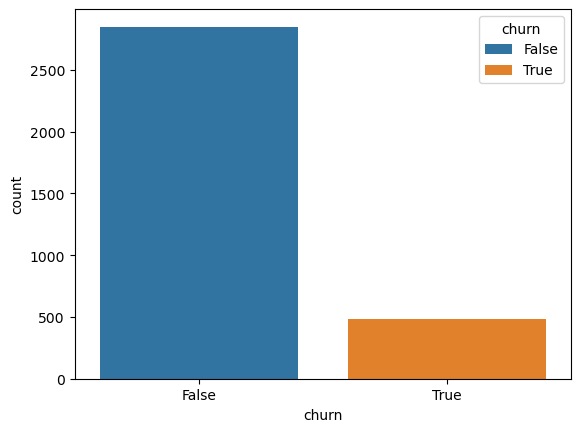

In [5]:
# Churn
print(df.churn.value_counts())
print()
print(df.churn.value_counts(normalize=True))
sns.countplot(data=df, x='churn',hue='churn');

In [6]:
#Perfoming label encoding
#False becomes 0 and True becomes 1
encoder = LabelEncoder()
df['churn'] = encoder.fit_transform(df['churn'])
df['churn'].value_counts()

churn
0    2850
1     483
Name: count, dtype: int64

### Categorical Columns

It looks like `phone_number` is an object type, not sure we can do anything with that information as far as predictions, but we can turn it into a unique identifier for the customer. `international_plan` and `voice_main_plan` can be transformed to a binary numeric format and `state` is nominal so can be transformed to numeric as well.

In [7]:
df.select_dtypes('object')

,state,phone_number,international_plan,voice_mail_plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no
...,...,...,...,...
3328,AZ,414-4276,no,yes
3329,WV,370-3271,no,no
3330,RI,328-8230,no,no
3331,CT,364-6381,yes,no


#### `phone_number`

Since there are no duplicates, we can confidently drop the phone_number column as each row is unique.

In [8]:
print(sum(df.phone_number.value_counts().values>1))

0


In [9]:
df.drop('phone_number', axis=1, inplace=True)

#### `state`

This is a nominal categorical variable and can be transformed to numeric by using methods like one-hot encoding or label encoding, depending on the specific requirements of the machine learning algorithm being used. We might even consider mapping states to their respective time zones to reduce the number of variables.

In [10]:
df['state'].value_counts()

state
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: count, dtype: int64

#### `international_plan` and `voice_mail_plan`

These variables can be transformed to a binary numeric format. With no set equal to zero and yes set equal to 1. Note that there are far more customers without international and voice mail plans.

international_plan
no     0.90309
yes    0.09691
Name: proportion, dtype: float64

voice_mail_plan
no     0.723372
yes    0.276628
Name: proportion, dtype: float64


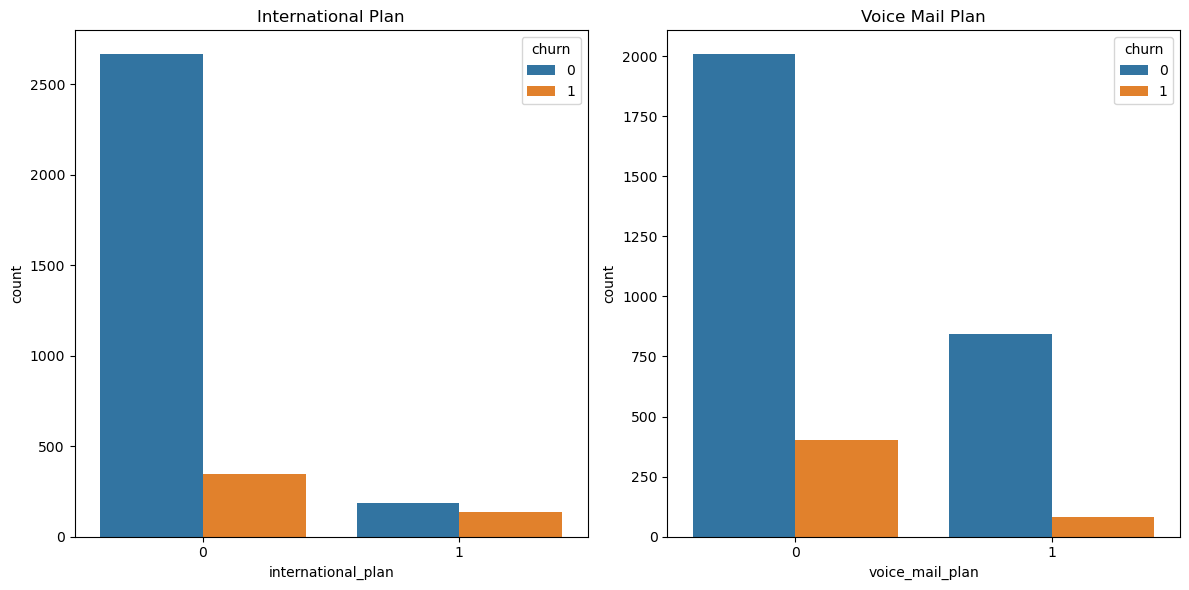

In [11]:
print(df['international_plan'].value_counts(normalize=True))
print()
print(df['voice_mail_plan'].value_counts(normalize=True))


#Performing label encoding
#No becomes 0 and yes becomes 1.
df['international_plan'] = encoder.fit_transform(df['international_plan'])
df['voice_mail_plan'] = encoder.fit_transform(df['voice_mail_plan'])

#Histograms
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first count plot
sns.countplot(x='international_plan', hue='churn', data=df, ax=axes[0])
axes[0].set_title('International Plan')

# Plot the second count plot
sns.countplot(x='voice_mail_plan', hue='churn', data=df, ax=axes[1])
axes[1].set_title('Voice Mail Plan')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Numeric Columns

Looking at numeric datatype columns, it seems like we might be able to consolidate certain information that seems to be telling us the same thing. We will have to see the correlations to make an informed decision.

In [12]:
df.select_dtypes('number')

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


Findings from the ditributions:
- `account_length`: There is a member who has been with the company around twice as long as the 75th percentile of customers.
- `area_code`: This is really a categorical variable. We can label encode this.
- `number_vmail_messages`: 50% of the dataset has zero voice mail messages, which might make sense since 72% of the customers do not have voice mail plans.

In [13]:
df.describe()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


### Correlation Analysis

Looking at the heatmap below, its clear that charge and minutes are perfectly correlated, which makes sense if the company is charging per minute. 
> If we need to, we can confidently drop the 'charge' column from each category; day, eve, night, and intl. We can keep the 'minutes' category as it is unclear what currency metric 'charge' is referring to.

There are a couple of weak correlations associated with our target `churn` variable; It seems `customer_service_calls`, `international_plan` and `total_day_minutes` have a slight positive correlation with churn. 
> While weak correlations, we would want to consider including these features in our models.

Lastly, there is a near perfect correlation between `number_vmail_messages` and `voice_mail_plan`, this makes sense and these two columns much like 'charge' and 'minutes' are telling us the same thing. 
> If we need to, we can drop `number_vmail_messages`.

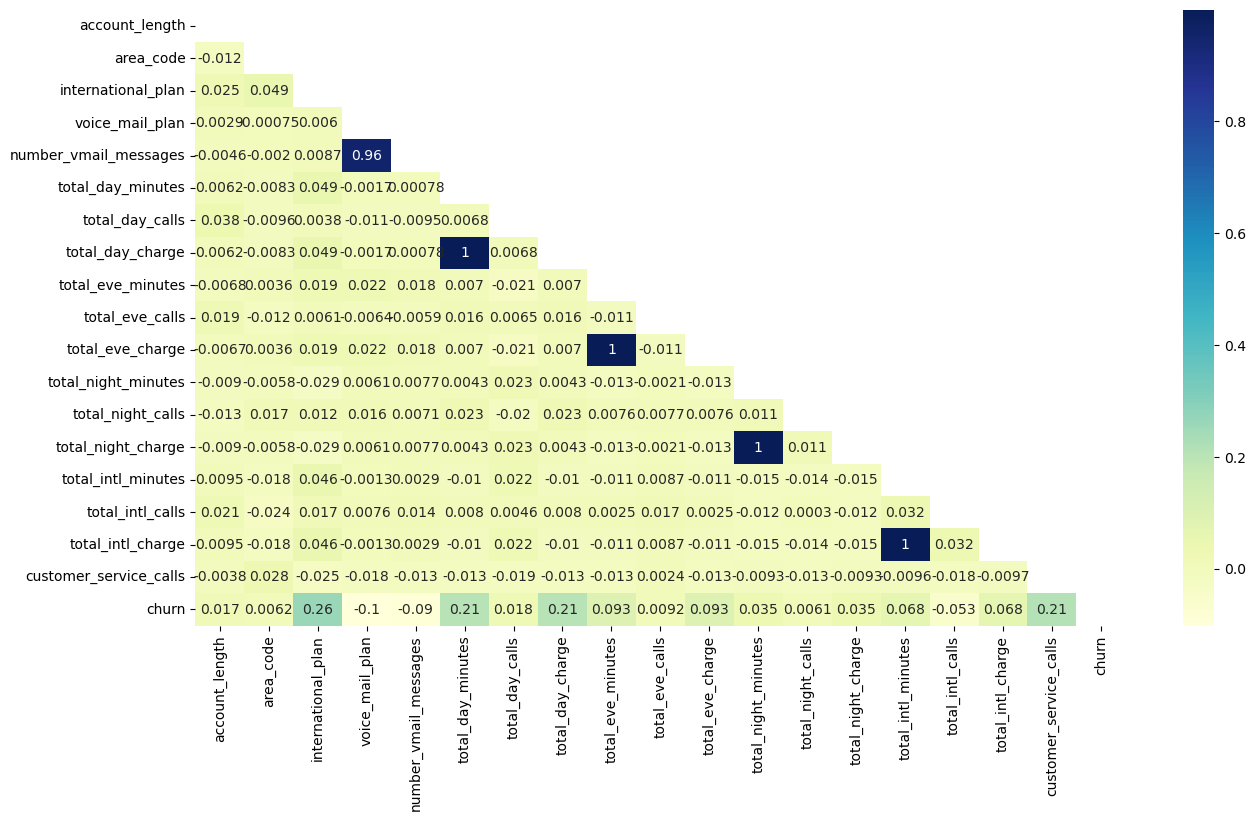

In [14]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(15,8))

corr_mx = df.select_dtypes('number').corr()

matrix = np.triu(corr_mx)

sns.heatmap(df.select_dtypes('number').corr(),annot=True, mask=matrix,cmap='YlGnBu');

## 4. Data Preperation

For our base model we will keep the train/test split as the default .75/.25 respectively. Since we know we have class imbalance, we will have `stratify = y` so our class proportions stay the same for both our train and test data.

In [15]:
# Define X and y, and split train/test data
df_copy = df.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [16]:
# Tranform 'state' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['state']]),columns=ohe.get_feature_names_out(['state']),index=X_train.index)
X_train.drop(columns=['state'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
556,123,408,0,0,0,159.5,77,27.12,303.8,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2596,73,408,0,0,0,122.0,92,20.74,138.3,114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,81,415,0,1,28,167.9,147,28.54,190.7,105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1152,16,408,0,0,0,209.5,89,35.62,172.8,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3060,94,415,0,0,0,212.1,98,36.06,189.4,89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,116,510,0,1,12,221.0,108,37.57,151.0,118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2165,160,415,0,0,0,171.2,103,29.10,243.5,121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,105,415,0,0,0,259.3,96,44.08,175.2,97,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
179,70,408,0,0,0,232.1,122,39.46,292.3,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Apply to X_test 

ohe_df = pd.DataFrame(ohe.transform(X_test[['state']]),columns=ohe.get_feature_names_out(['state']),index=X_test.index)
X_test.drop(columns=['state'],axis=1,inplace=True)
X_test = pd.concat([X_test,ohe_df],axis=1)

In [18]:
# Tranform 'area_code' column with OneHotEncoder

ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['area_code']]),columns=ohe.get_feature_names_out(['area_code']),index=X_train.index)
X_train.drop(columns=['area_code'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
556,123,0,0,0,159.5,77,27.12,303.8,92,25.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2596,73,0,0,0,122.0,92,20.74,138.3,114,11.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,81,0,1,28,167.9,147,28.54,190.7,105,16.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1152,16,0,0,0,209.5,89,35.62,172.8,85,14.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3060,94,0,0,0,212.1,98,36.06,189.4,89,16.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,116,0,1,12,221.0,108,37.57,151.0,118,12.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2165,160,0,0,0,171.2,103,29.10,243.5,121,20.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2988,105,0,0,0,259.3,96,44.08,175.2,97,14.89,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
179,70,0,0,0,232.1,122,39.46,292.3,112,24.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Apply to X_test

ohe_df = pd.DataFrame(ohe.transform(X_test[['area_code']]),columns=ohe.get_feature_names_out(['area_code']),index=X_test.index)
X_test.drop(columns=['area_code'],axis=1,inplace=True)
X_test = pd.concat([X_test,ohe_df],axis=1)
X_test

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
2974,201,0,0,0,212.7,72,36.16,225.2,90,19.14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2791,151,0,0,0,194.8,106,33.12,292.7,103,24.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,141,1,1,37,258.6,84,43.96,222.0,111,18.87,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3131,107,0,0,0,189.7,76,32.25,156.1,65,13.27,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
872,149,0,1,43,206.7,79,35.14,174.6,122,14.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,123,0,0,0,166.9,98,28.37,221.8,77,18.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1325,17,0,1,31,153.1,115,26.03,185.9,59,15.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1018,76,0,0,0,263.4,148,44.78,230.3,69,19.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
596,124,0,0,0,157.5,70,26.78,130.7,79,11.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5. 1st Model

Give that all our features in the right format, we can build our base model with `DummyClassifier` using the `stratified` strategy since we have an imbalanced dataset skewed in the direction of class 0 when we are interested in predicting class 1.

In [20]:
# Initiate base model with DummyClassifer

base = DummyClassifier(strategy = 'stratified',random_state=42)
base.fit(X_train,y_train)

DummyClassifier(random_state=42, strategy='stratified')

Off the bat, we have a pretty good accuracy, for our business initiative we will be more focused on getting a good recall score, so it is good that our base data has a decent accuracy score. We will want to find an approriate balance between the two.

In [21]:
base.score(X_train, y_train)

0.7527010804321729

### Model with Cross Validation Class
We created a class to help us run Cross Validation more easily on other models.

In [22]:
class ModCrossVal():
    '''Create model and see the crossvalidation more easily'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
    
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None
    
        if cv_now:
            self.cross__val()
    
    def cross__val(self,X=None,y=None, kfolds=5):
        '''
        Perform cross validation and return results.
    
        Args:
         X:
          Optional; Training data to perform CV on. Otherwise use X from object
         y:
          Optional; Training data to perform CV on. Otherwise use y from object
         kfolds:
          Optional; Number of folds for CV (default is 10)  
        '''
    
        cv_X = X if X else self.X
        cv_y = y if y else self.y
    
        self.cv_results = cross_validate(self.model,cv_X,cv_y,scoring='recall',return_train_score=True,cv=kfolds)
        self.cv_train_mean = np.mean(self.cv_results['train_score'])
        self.cv_test_mean = np.mean(self.cv_results['test_score'])
        self.cv_test_std = np.std(self.cv_results['test_score'])

    
    def cv_summary(self):
        
        summary = {
            'model_name':self.name,'cv_train_mean':self.cv_train_mean,
            'cv_test_mean':self.cv_test_mean,'cv_test_std':self.cv_test_std
        }
    
        cv_summary = pd.DataFrame(summary,columns=['model_name','cv_train_mean','cv_test_mean','cv_test_std'],
                                  index=range(1))
        return cv_summary        

To start, we will fit our data to a `LogisiticRegression` model with a `liblinear` solver so that we can potentially test both L1 and L2 penalties.

In [23]:
# Initate our first Logistic Regression model with all of our features included

logreg_model = LogisticRegression(random_state=42,solver='liblinear')
logreg_model.fit(X_train,y_train)

LogisticRegression(random_state=42, solver='liblinear')

Comparing our first `LogisticRegression` model with our `base`, we can see that our `LogisticRegression` model does somewhat better at predicting `churn` with a higher True Positive Rate than our `base`.

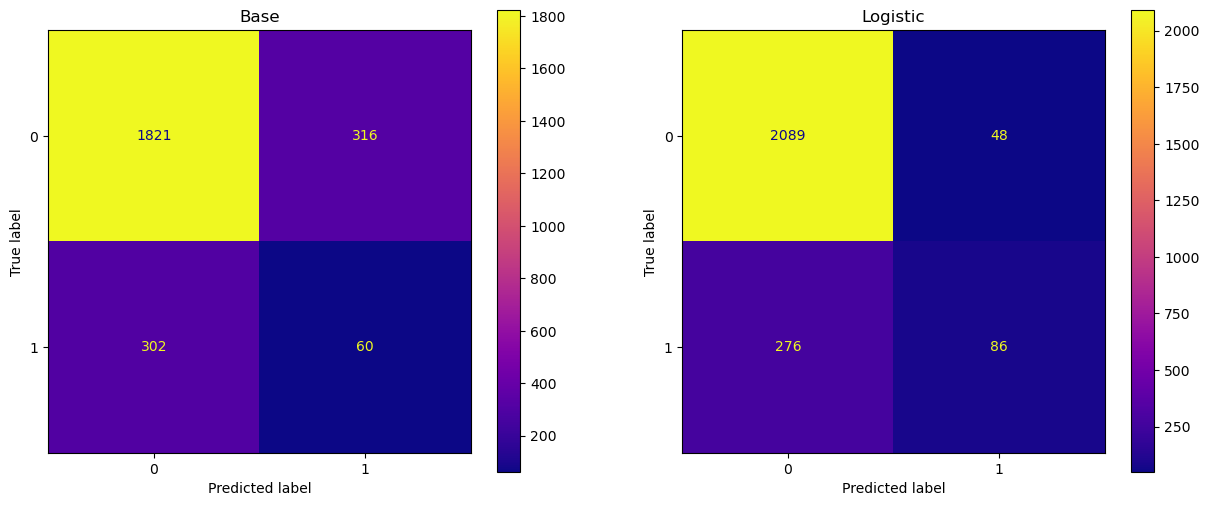

In [24]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Base')
ax[1].set_title('Logistic')

ConfusionMatrixDisplay.from_estimator(base,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[1],cmap='plasma');

Next, we can try fitting the `LogisticRegression` model with an L1 penalty.

In [25]:
logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=300)
logreg_model_l1.fit(X_train,y_train)

LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                   solver='liblinear')

### Compare L1 and L2 solvers

It looks like the Logisic L1 model does better than both previous models but only slightly. However our class imbalance makes it difficult to assess accurately and needs to be addressed.

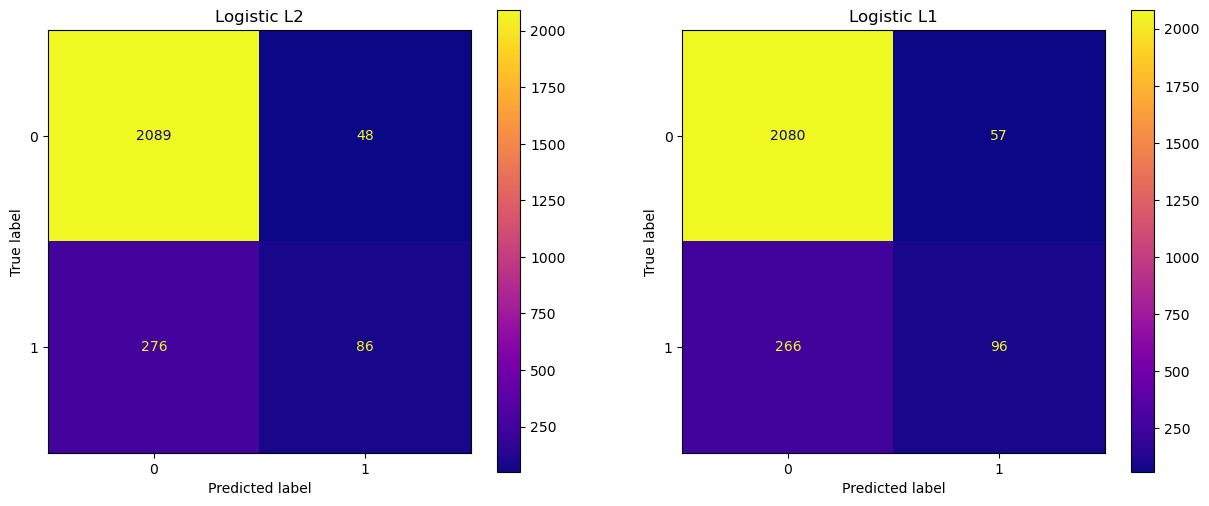

In [26]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Logistic L2')
ax[1].set_title('Logistic L1')

ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train,y_train,ax=ax[1],cmap='plasma');

### Class Imbalance with `SMOTE`

We can easily resample and even out the distribution among the classes. 

In [27]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

churn
0    2137
1     362
Name: count, dtype: int64
------------------------------
Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


### Model with Cross Validation

Now we have cross validated our results to finalize our 1st model with `LogisiticRegression`.

It looks like our model performs nearly the same on the train and test (validation) data. We can probably get this even higher after we simplify our model some more.

In [28]:
# Refit with resampled training data

logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1', max_iter=500)
logreg_model_l1.fit(X_train_resampled,y_train_resampled)

LogisticRegression(max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

In [29]:
# Cross validate with ModCrossVal class

mcv = ModCrossVal(logreg_model_l1, "Logistic L1", X_train_resampled, y_train_resampled)
logreg_l1_sum = mcv.cv_summary()
logreg_l1_sum

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logistic L1,0.781002,0.766504,0.017464


### Finetune `C` with Cross Validation

We should also perform cross validation with finetune'd `C` to assess what level of penalty is best for our model.

In [30]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
l1_results = pd.DataFrame()

for c in C_values:
    logreg_l1 = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=500)
    logreg_l1.fit(X_train_resampled, y_train_resampled)
    new_results = ModCrossVal(logreg_l1, f'Logreg L1 c{c:e}', X_train_resampled, y_train_resampled)
    l1_results = pd.concat([l1_results, new_results.cv_summary()])
    l1_results.index=range(len(l1_results))
    
    l1_results

In [31]:
l1_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
l1_results

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logreg L1 c1.000000e-04,0.955670,0.949421,0.058310
3,Logreg L1 c1.000000e-01,0.781703,0.769764,0.029778
4,Logreg L1 c1.000000e+00,0.781002,0.766504,0.017464
2,Logreg L1 c1.000000e-02,0.713032,0.707542,0.024274
1,Logreg L1 c1.000000e-03,0.566566,0.567145,0.026597


In [32]:
# Run optimized model

logregl1_opt = LogisticRegression(random_state=42, C=0.0001, solver='liblinear', penalty='l1')
logregl1_opt = logregl1_opt.fit(X_train_resampled,y_train_resampled)

In [33]:
# Define get_recall function

recall_results = []

def get_recall(model,model_name,X,y):

    recall = recall_score(y,model.predict(X))

    summary = {
        'model_name':f'{model_name}', 'recall_score':recall
    }
    summary_df = pd.DataFrame(summary,columns=['model_name','recall_score'],index=range(1))

    return summary_df

Our optimized results after finetuning the `C` look pretty good, though slightly less than before optimizing `C`. Once we attempt to simplify some more, we will want to look at other scores such as accuracy and precision to make sure our results are balanced enough for the business problem at hand.

In [34]:
# Get final train recall

logregl1_recall = get_recall(model=logregl1_opt,model_name="Logistic L1",X=X_train_resampled,y=y_train_resampled)
logregl1_recall

,model_name,recall_score
0,Logistic L1,0.754796


We will create a data frame to collect all of our scores pertaining to our optimized versions of each model under consideration.

In [35]:
# Initiate model results df

def concat_results(recall_results):
    recall_summary = pd.DataFrame()
    recall_summary = pd.concat(recall_results)
    recall_summary.index=range(len(recall_summary))
    return recall_summary

recall_results = [logregl1_recall]

## 6. 2nd Model

Since we know that there are features that are highly correlated we will use `SelectFromModel` to select features for us that are most important.

In [36]:
# Initiate selector
selector = SelectFromModel(logreg_model_l1)

# Using the original resampling from first SMOTE initiation
selector.fit(X_train,y_train)

SelectFromModel(estimator=LogisticRegression(max_iter=500, penalty='l1',
                                             random_state=42,
                                             solver='liblinear'))

In [37]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

We will use the default threshold to start and identify which features meet threshold requirements. Since we are still using our L1 Logistic model, the default threshold will be $1e^-5$.

It looks like there are several features that do not meet the threshold.

In [38]:
# Initate get_support 

sup = selector.get_support()

unique, counts = np.unique(sup,return_counts=True)

# Print as array and transpose to see count of features that do not meet the threshold
print(np.asarray((unique,counts)).T)

[[ 0 16]
 [ 1 53]]


In [39]:
# Create dictionary matching results with features

dict(zip(X_train.columns,selector.get_support()))

{'account_length': True,
 'international_plan': True,
 'voice_mail_plan': True,
 'number_vmail_messages': True,
 'total_day_minutes': True,
 'total_day_calls': True,
 'total_day_charge': True,
 'total_eve_minutes': True,
 'total_eve_calls': True,
 'total_eve_charge': True,
 'total_night_minutes': True,
 'total_night_calls': True,
 'total_night_charge': False,
 'total_intl_minutes': True,
 'total_intl_calls': True,
 'total_intl_charge': False,
 'customer_service_calls': True,
 'state_AL': True,
 'state_AR': False,
 'state_AZ': True,
 'state_CA': True,
 'state_CO': False,
 'state_CT': True,
 'state_DC': True,
 'state_DE': True,
 'state_FL': True,
 'state_GA': False,
 'state_HI': True,
 'state_IA': False,
 'state_ID': True,
 'state_IL': True,
 'state_IN': False,
 'state_KS': True,
 'state_KY': True,
 'state_LA': False,
 'state_MA': False,
 'state_MD': True,
 'state_ME': True,
 'state_MI': True,
 'state_MN': True,
 'state_MO': False,
 'state_MS': True,
 'state_MT': True,
 'state_NC': False

In [40]:
# Recreate X_train with best features out

X_train_slct = select_important_features(X=X_train, selector=selector)

X_train_slct

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WY,area_code_415,area_code_510
556,123.0,0.0,0.0,0.0,159.5,77.0,27.12,303.8,92.0,25.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2596,73.0,0.0,0.0,0.0,122.0,92.0,20.74,138.3,114.0,11.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,81.0,0.0,1.0,28.0,167.9,147.0,28.54,190.7,105.0,16.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1152,16.0,0.0,0.0,0.0,209.5,89.0,35.62,172.8,85.0,14.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3060,94.0,0.0,0.0,0.0,212.1,98.0,36.06,189.4,89.0,16.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,116.0,0.0,1.0,12.0,221.0,108.0,37.57,151.0,118.0,12.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2165,160.0,0.0,0.0,0.0,171.2,103.0,29.10,243.5,121.0,20.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2988,105.0,0.0,0.0,0.0,259.3,96.0,44.08,175.2,97.0,14.89,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
179,70.0,0.0,0.0,0.0,232.1,122.0,39.46,292.3,112.0,24.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Recreate X_test with best features out

X_test_slct = select_important_features(X=X_test, selector=selector)

X_test_slct

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WY,area_code_415,area_code_510
2974,201.0,0.0,0.0,0.0,212.7,72.0,36.16,225.2,90.0,19.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2791,151.0,0.0,0.0,0.0,194.8,106.0,33.12,292.7,103.0,24.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,141.0,1.0,1.0,37.0,258.6,84.0,43.96,222.0,111.0,18.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3131,107.0,0.0,0.0,0.0,189.7,76.0,32.25,156.1,65.0,13.27,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
872,149.0,0.0,1.0,43.0,206.7,79.0,35.14,174.6,122.0,14.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,123.0,0.0,0.0,0.0,166.9,98.0,28.37,221.8,77.0,18.85,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1325,17.0,0.0,1.0,31.0,153.1,115.0,26.03,185.9,59.0,15.80,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1018,76.0,0.0,0.0,0.0,263.4,148.0,44.78,230.3,69.0,19.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
596,124.0,0.0,0.0,0.0,157.5,70.0,26.78,130.7,79.0,11.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Resample with selected features

smote = SMOTE(random_state=42)
X_train_resamp_slct, y_train_resamp_slct = smote.fit_resample(X_train_slct,y_train)

#### Run and Cross Validate

Now we can run our cross validation again to see how it does in comparison to the other model and it's own validation set.

In [43]:
logreg_slct = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=500)
logreg_slct.fit(X_train_resamp_slct,y_train_resamp_slct)

LogisticRegression(max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

It looks like our selected feature model did around the same as our Logistic L1 model before finetuning. It is worth noting that this is a simpler model as it has reduced features. 

In [44]:
mcv = ModCrossVal(logreg_slct,'Logistic Select', X_train_resamp_slct,y_train_resamp_slct)
logreg_sel_sum = mcv.cv_summary()
logreg_sel_sum

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logistic Select,0.811652,0.806288,0.03124


#### Finetune `C` with Cross Validation

Just like our Logreg L1 model, the Logreg Select model does best with smaller `C` values, so we will want to use the smallest value with our optimized model.

In [45]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
slct_results = pd.DataFrame()

for c in C_values:
    logreg_select = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=500)
    logreg_select.fit(X_train_resamp_slct, y_train_resamp_slct)
    new_results = ModCrossVal(logreg_select, f'Logreg Select c{c:e}', X_train_resamp_slct, y_train_resamp_slct)
    slct_results = pd.concat([slct_results, new_results.cv_summary()])
    slct_results.index=range(len(slct_results))

    slct_results

In [46]:
slct_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
slct_results

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logreg Select c1.000000e-04,0.953097,0.948018,0.058589
4,Logreg Select c1.000000e+00,0.811652,0.806288,0.031240
3,Logreg Select c1.000000e-01,0.791180,0.785690,0.025930
2,Logreg Select c1.000000e-02,0.765325,0.757606,0.026863
1,Logreg Select c1.000000e-03,0.566800,0.566671,0.030958


In [47]:
# Run optimized model

logreg_slct_opt = LogisticRegression(random_state=42, C=0.0001, solver='liblinear', penalty='l1')
logreg_slct_opt = logreg_slct_opt.fit(X_train_resamp_slct,y_train_resamp_slct)

Our Logistic Select model did pretty well though It performed around the same as our first Logtistic model after optimization.

In [48]:
# Get optimized results

logreg_slct_recall = get_recall(logreg_slct_opt,'Logistic Select', X_train_resamp_slct,y_train_resamp_slct,)
logreg_slct_recall

,model_name,recall_score
0,Logistic Select,0.751989


### Compare Models

Comparing both `recall` metrics and Confusion Matrices of the two models so far, it looks like our second Logistic Regression model is performing slightly better after optimization of the `C` parameter.

In [49]:
# Compare final train recall

recall_results.append(logreg_slct_recall)

concat_results(recall_results)

,model_name,recall_score
0,Logistic L1,0.754796
1,Logistic Select,0.751989


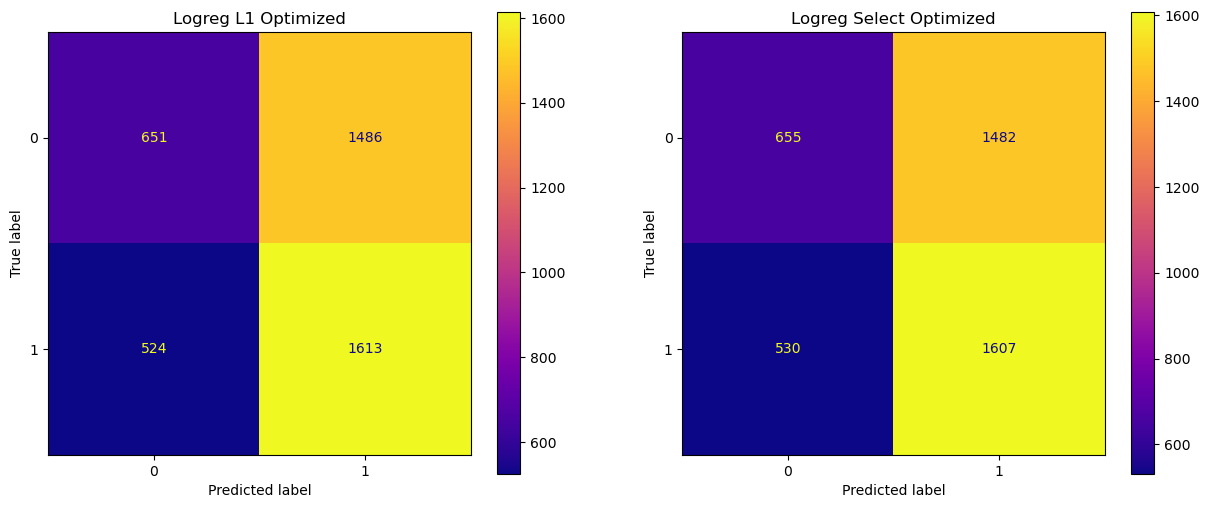

In [50]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Logreg L1 Optimized')
ax[1].set_title('Logreg Select Optimized')

ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_train_resampled,y_train_resampled,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_train_resamp_slct,y_train_resamp_slct,ax=ax[1],cmap='plasma');

## 7. 3rd Model

For our final itteration of the LogisticRegression model we should try manual feature selection with features we know to be highly correlated with `churn`. 

In [51]:
#Excluding total international minutes
highly_correlated_variables = df[['international_plan', 'total_day_minutes', 'total_eve_minutes', 
                                  'total_intl_minutes', 'customer_service_calls', 'churn']]
highly_correlated_variables.head()

,international_plan,total_day_minutes,total_eve_minutes,total_intl_minutes,customer_service_calls,churn
0,0,265.1,197.4,10.0,1,0
1,0,161.6,195.5,13.7,1,0
2,0,243.4,121.2,12.2,0,0
3,1,299.4,61.9,6.6,2,0
4,1,166.7,148.3,10.1,3,0


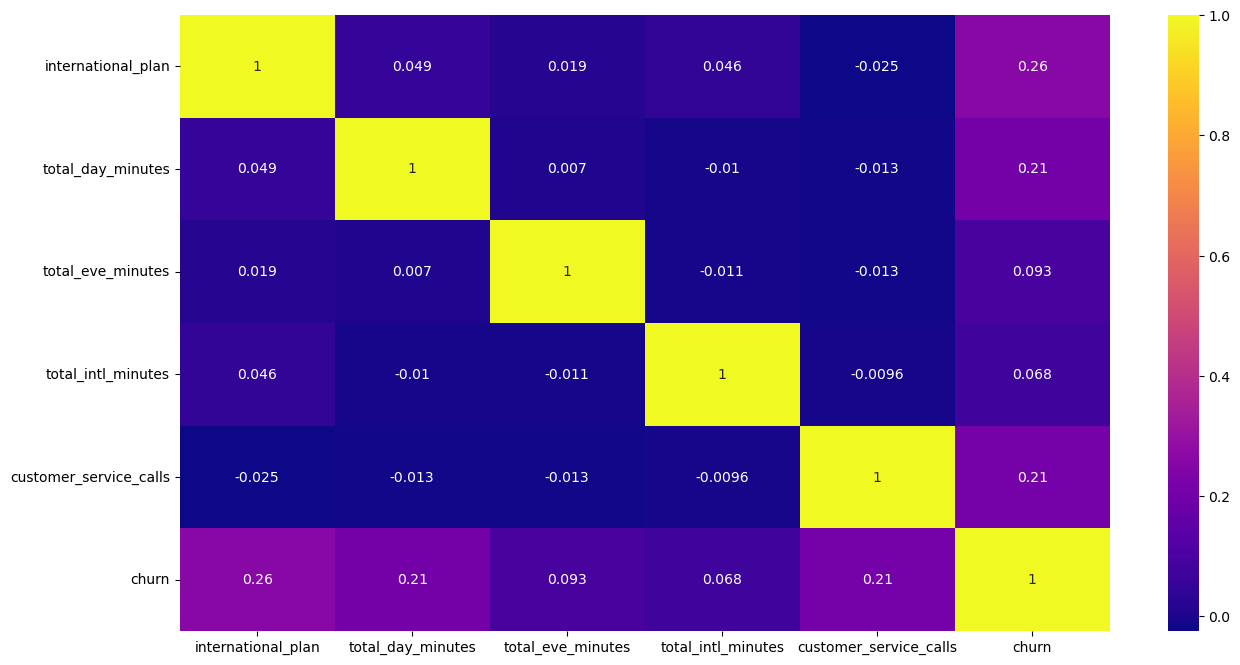

In [52]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(highly_correlated_variables.corr(),annot=True,cmap='plasma');

In [53]:
# Define X and y, and split train/test data
df_copy = highly_correlated_variables.copy()

X_red = df_copy.drop(columns=['churn'],axis=1)
y_red = df_copy['churn']

X_train_red, X_test_red, y_train_red, y_test_red= train_test_split(X_red,y_red,random_state=42,stratify=y)

In [54]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_red_resamp, y_train_red_resamp = smote.fit_resample(X_train_red,y_train_red)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_red_resamp).value_counts())

Original Class Distribution: 

churn
0    2137
1     362
Name: count, dtype: int64
------------------------------
Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


### Run and Cross Validate

In [55]:
logreg_red = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_red.fit(X_train_red_resamp, y_train_red_resamp)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

Before finetuning, our model performs slightly worse than our previous two.

In [56]:
mcv = ModCrossVal(logreg_red,'Logistic Reduced', X_train_red_resamp, y_train_red_resamp)
logreg_red_sum = mcv.cv_summary()
logreg_red_sum

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logistic Reduced,0.715489,0.710818,0.036467


### Finetune `C` with Cross Validation

As with other models, the smallest `C` values gives us the best results. We will again, use this value within our optimized results.

In [57]:
C_values = [0.00015, 0.0002, 0.0015, 0.002, .015]
reduced_results = pd.DataFrame()

for c in C_values:
    logreg_red = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=500)
    logreg_red.fit(X_train_red_resamp, y_train_red_resamp)
    new_results = ModCrossVal(logreg_red, f'Logreg Reduced c{c:e}', X_train_red_resamp, y_train_red_resamp)
    reduced_results = pd.concat([reduced_results, new_results.cv_summary()])
    reduced_results.index = range(len(reduced_results))
    
    reduced_results

In [58]:
reduced_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
reduced_results

,model_name,cv_train_mean,cv_test_mean,cv_test_std
0,Logreg Reduced c1.500000e-04,0.993449,0.992514,0.004998
1,Logreg Reduced c2.000000e-04,0.872834,0.873193,0.031108
2,Logreg Reduced c1.500000e-03,0.720753,0.721571,0.005787
3,Logreg Reduced c2.000000e-03,0.718764,0.718764,0.004803
4,Logreg Reduced c1.500000e-02,0.700632,0.700055,0.019202


In [59]:
# Run optimized model

logreg_red_opt = LogisticRegression(random_state=42, C=0.00015, solver='liblinear', penalty='l1')
logreg_red_opt = logreg_red_opt.fit(X_train_red_resamp, y_train_red_resamp)

e get a pretty good recall score after optimizing! We will definitely want to make sure we balance accuracy within our decision making process. All in all, it seems like our manual feature selection yields the best recall.

In [60]:
# Get optimized score

logreg_red_recall = get_recall(logreg_red_opt,'Logistic Reduced', X_train_red_resamp, y_train_red_resamp)
logreg_red_recall

,model_name,recall_score
0,Logistic Reduced,0.899392


### Compare Optimized Logistic Models

Comparing confusion matrices of all 3 `LogisticRegression` models, our most recent Logistic Reduced model does best at predicting True Positives (customers going to churn) and reducing False Negatives (customers appearing to be retained but who actually churn).

This can provide valuable intervention insights to our stakeholders given a strategic approach to address the high amount False Positives (customers appearing to potentially churn but actually end up retained).

In [61]:
# Compare final train recall for all Logistic Models

recall_results.append(logreg_red_recall)

concat_results(recall_results)

,model_name,recall_score
0,Logistic L1,0.754796
1,Logistic Select,0.751989
2,Logistic Reduced,0.899392


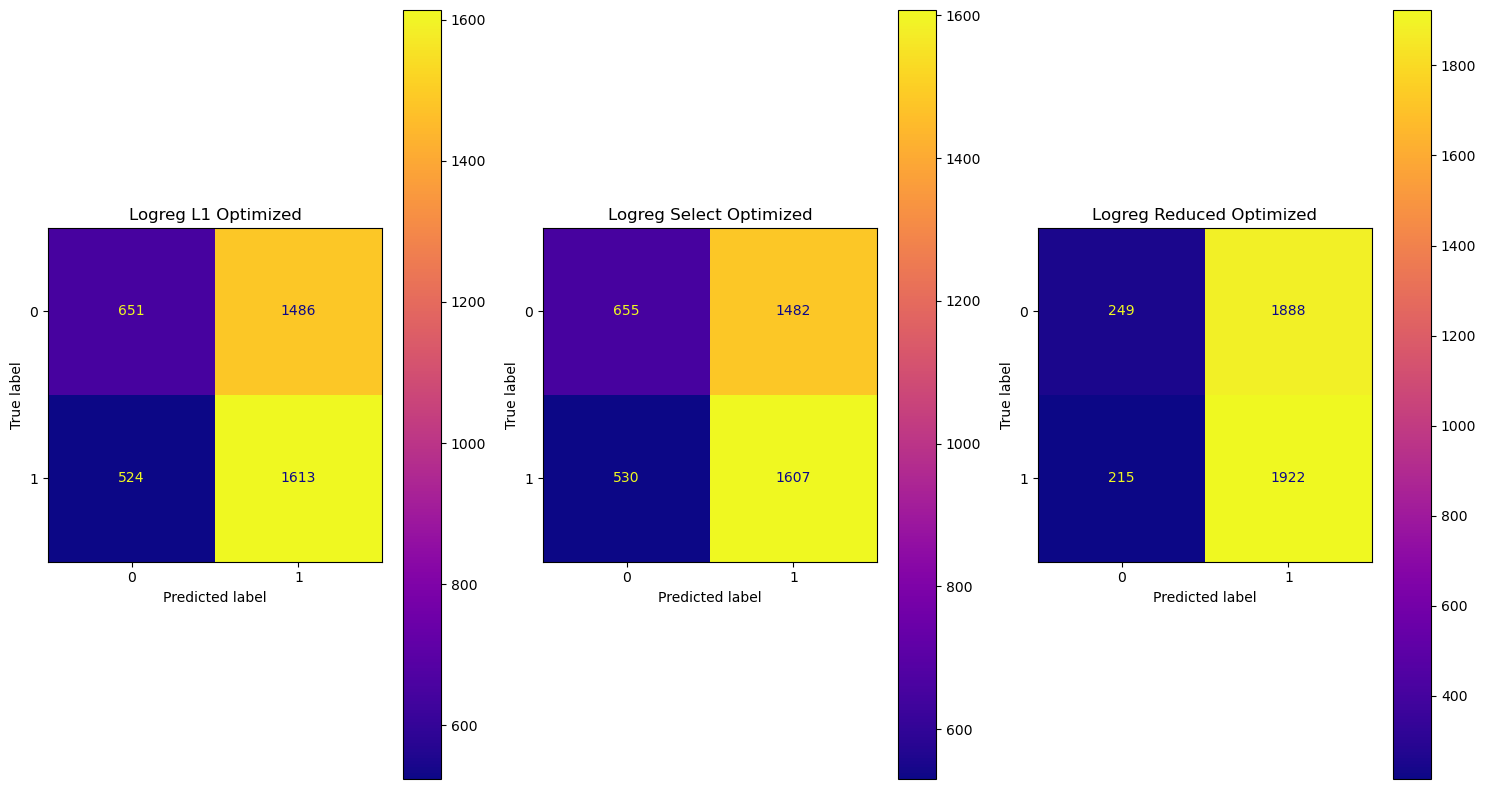

In [62]:
fig, ax = plt.subplots(ncols=3,figsize=(15,8))

ax[0].set_title('Logreg L1 Optimized')
ax[1].set_title('Logreg Select Optimized')
ax[2].set_title('Logreg Reduced Optimized')

ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_train_resampled,y_train_resampled,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_train_resamp_slct,y_train_resamp_slct,ax=ax[1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_red_opt,X_train_red_resamp, y_train_red_resamp,ax=ax[2],cmap='plasma')

plt.tight_layout();

## 8. Run Final Models on Test

We will now run our models with test data and evaluate each classification report associated. As expected, our 3rd Model produces the highest recall. As this is our primary focus for **Phase 1** of this business initiative we will want to recommend deployment of this model and address the concerns regarding our lower precision and accuracy scores within our approach recommendations as well as next steps.

In [63]:
#Make predictions on test data
y_pred_1 = logregl1_opt.predict(X_test)
y_pred_2 = logreg_slct_opt.predict(X_test_slct)
y_pred_3 = logreg_red_opt.predict(X_test_red)

In [64]:
# Run classification report on all models
for i, y_pred in enumerate([y_pred_1, y_pred_2, y_pred_3]):
    if y_pred[i] == y_pred[3]:
        print(f'Classification report for Model {i+1}:\n')
        print(classification_report(y_test_red,y_pred))
    else:
        print(f'Classification report for Model {i+1}:\n')
        print(classification_report(y_test,y_pred))

Classification report for Model 1:

              precision    recall  f1-score   support

           0       0.91      0.32      0.48       713
           1       0.17      0.81      0.28       121

    accuracy                           0.39       834
   macro avg       0.54      0.57      0.38       834
weighted avg       0.80      0.39      0.45       834

Classification report for Model 2:

              precision    recall  f1-score   support

           0       0.91      0.33      0.48       713
           1       0.17      0.81      0.28       121

    accuracy                           0.40       834
   macro avg       0.54      0.57      0.38       834
weighted avg       0.80      0.40      0.45       834

Classification report for Model 3:

              precision    recall  f1-score   support

           0       0.96      0.13      0.24       713
           1       0.16      0.97      0.27       121

    accuracy                           0.26       834
   macro avg       0

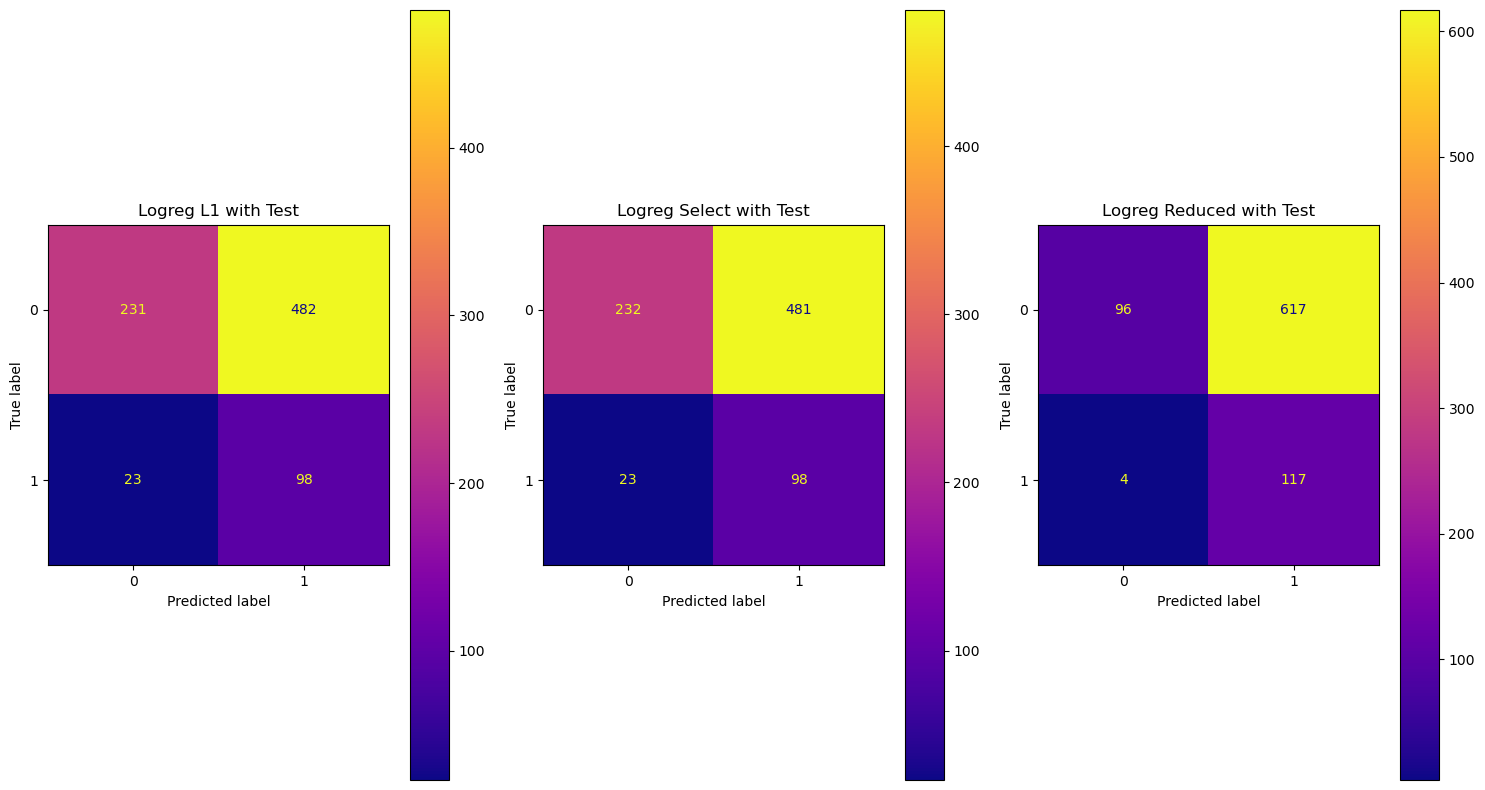

In [65]:
fig, ax = plt.subplots(ncols=3,figsize=(15,8))

ax[0].set_title('Logreg L1 with Test')
ax[1].set_title('Logreg Select with Test')
ax[2].set_title('Logreg Reduced with Test')

ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_test,y_test,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_test_slct,y_test,ax=ax[1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_red_opt,X_test_red, y_test_red,ax=ax[2],cmap='plasma')

plt.tight_layout();

## 9. 4th Model

As stated, we will now construct and run a `DecisionTreeClassifier` on the dataset defined in our most recent model. We will also call on `GridSearchCV` to help us find the best parameters for our decision tree to run and result in the best recall score while also performing cross validation.

No other preparation is necessary as it was addressed when prepping our previous model.

In [66]:
# Define the parameters to search
tree_params = {
    'max_depth': list(range(1, 20)),
    'min_samples_split': list(range(2, 11)),  # Values from 2 to 10
    'min_samples_leaf': list(range(1, 5)),  # Values from 1 to 4
    'max_features': list(range(1, X_red.shape[1] + 1)),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

# Create a DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)

# Create GridSearchCV object
clf = GridSearchCV(dtc, tree_params, cv=5, scoring='recall', return_train_score=True)

# Fit the model
clf.fit(X_train_red_resamp, y_train_red_resamp)

# Print the best parameters found
print("Best Parameters:", clf.best_params_)

# Print the best score found
print("Best Recall Score:", clf.best_score_)

# Print the best score std
print("Best Recall Score STD:", clf.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best Recall Score: 0.9358729672350018
Best Recall Score STD: 0.9358729672350018


Our results look great! These recall scores are the highest we've seen, even after optimizing the other models. We are also not seeing any overfitting or underfitting since both train and test(validation) scores are balanced. Although, this was also the case with our other models so we have to run the test to be certain that this model doesn't pose the same issue.

In [67]:
cv_results = {
    "Metrics": ['Mean Train Score', 'Train Standard Deviation Score',
               'Mean Test Score', 'Test Standard Deviation Score'],
    "Values": [
        clf.cv_results_['mean_train_score'][clf.best_index_],
        clf.cv_results_['std_train_score'][clf.best_index_],
        clf.cv_results_['mean_test_score'][clf.best_index_],
        clf.cv_results_['std_test_score'][clf.best_index_]
    ]
}

tree_summary = pd.DataFrame(cv_results, columns=['Metrics', 'Values'])

tree_summary

,Metrics,Values
0,Mean Train Score,0.942445
1,Train Standard Deviation Score,0.015990
2,Mean Test Score,0.935873
3,Test Standard Deviation Score,0.043065


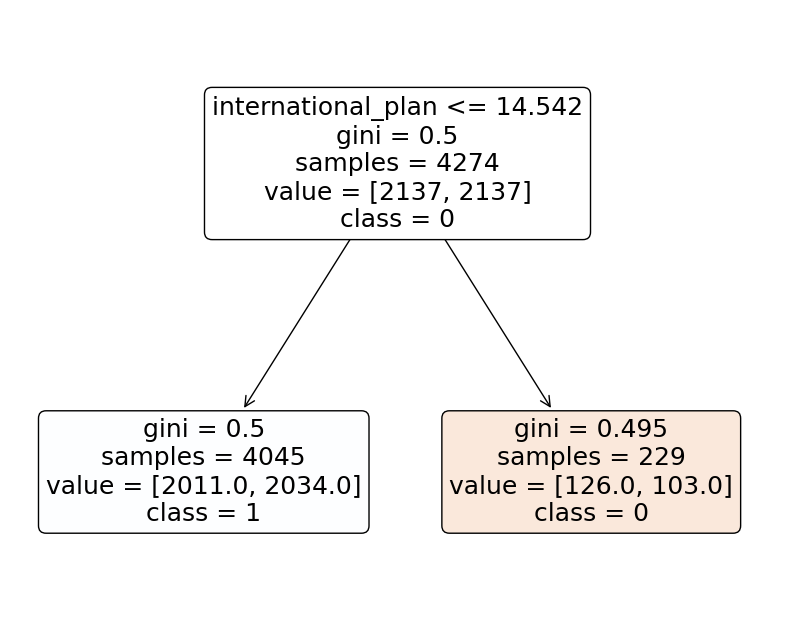

In [68]:
# Plot the decision tree of the best model
best_model = clf.best_estimator_
plt.figure(figsize=(10, 8))
plot_tree(best_model, filled=True, rounded=True, class_names=['0', '1'], feature_names=X.columns)
plt.show()

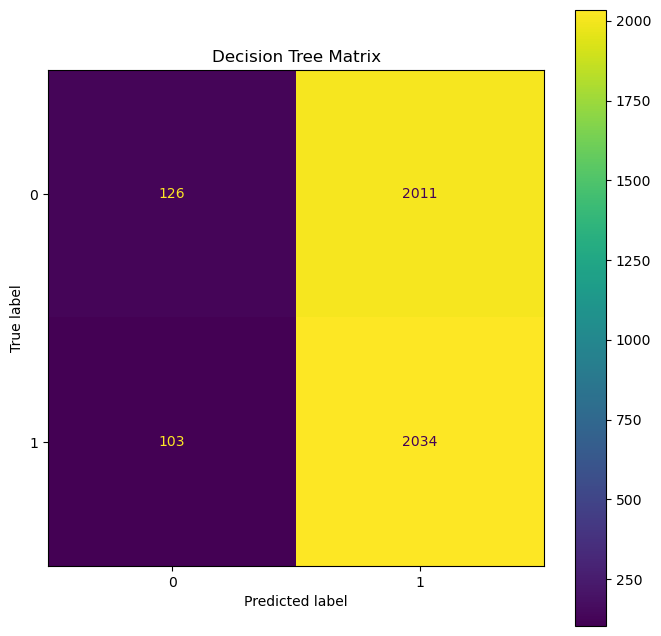

In [69]:
# Plot confusion matrix of the best model

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Decision Tree Matrix')

ConfusionMatrixDisplay.from_estimator(best_model, X_train_red_resamp, y_train_red_resamp, 
                                      display_labels=['0', '1'], ax=ax)

plt.show()

In [70]:
# Print classification report
y_pred_test = best_model.predict(X_test_red)

print(classification_report(y_test_red,y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.04      0.07       713
           1       0.15      0.98      0.25       121

    accuracy                           0.17       834
   macro avg       0.52      0.51      0.16       834
weighted avg       0.78      0.17      0.09       834



## 10. Final Evaluation & Conclusion

After becoming aware of the underfitting issues with our `LogisticRegression` and running a `DecisionTreeClassifier` it is clear that the latter is the clear choice for this <ins>_Phase 1_</ins> of the business initiative. This model provides the highest Recall or True Postive Rate and most closely satisfies the goals. Below we go into detail regarding this decision including additional recommendation on intervention approach.

**Recommendations:**

As this is <ins>_Phase 1_</ins> of the project, we are hyper focused on identifying True Positive cases while reducing False Negative instances. Therefore, we are primarily focused on recall or true positive rate.

To account for our recall-focused path, a variety of low touch to high touch engagement models is recommended to account for the high number of False Positives within these models. An automated low touch model to start and gather data on customer satisfaction of those predicted to churn will yeild best results. Acting accordingly with a scaled  approach given the feedback collected will be crutial and create a positive customer experience for all.

**Positive Implications:**

<ins>_Customer Retention:_</ins> High recall means that your model is effective at identifying customers who are likely to churn. This allows the business to proactively intervene and take steps to retain these customers, such as offering incentives, personalized promotions, or improved customer service.

<ins>_Reduced Churn:_</ins> By effectively targeting at-risk customers, you may be able to reduce the overall churn rate, leading to increased customer retention and long-term profitability.

**Negative Implications:**

<ins>_Costs:_</ins> A low precision score means that there may be a significant number of false positives, leading to unnecessary costs associated with retaining customers who were not actually at risk of churning. These costs may include incentives or discounts offered to retain customers. 

<ins>_Customer Experience:_</ins> Misclassifying customers who were not actually at risk of churning as "churners" may lead to unnecessary interventions or communications, potentially impacting the customer experience negatively.

**Data Limitation and Future Considerations:**

In <ins>_Phase 2_</ins> of the business initiative, when looking to optimize our results and produce the most accurate prediction of customers who are likely to churn, we find that it may be best to use a combination of classifier models to balance precision and recall. However, given the need to edit the training data, this posed an issue.

We would also recommend gathering additional data to account for class imbalance and revising which feature hold importance in relation to churn. Obtaining a larger dataset will also help resolve the underfitting issues we saw in our `LogisticRegression` models.

By simplifying the data before modeling, we are more likely to yield positive results and open up options to combine models using the same training data for a more balanced learning mechanism.